## TGS Salt Identification

![alt text](https://pbs.twimg.com/media/DilKBjUVsAA74j1.jpg)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook 
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [6]:
## Read data
train = pd.read_csv("./data/train.csv",index_col='id',usecols=[0])

In [7]:
depths = pd.read_csv("./data/depths.csv",index_col="id")

In [8]:
train=train.join(depths)

In [ ]:
## Read images

train["images"] = [np.array(load_img("./data/train/images/{}.png".format(i),grayscale=True))/255 for i in tqdm_notebook(train.index)]

In [ ]:
train["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(i),grayscale=True))/255 for i in tqdm_notebook(train.index)]

In [11]:
train["coverage"]=train.masks.map(np.sum)/pow(101,2)

In [12]:
def get_salt_class(cov):
    for i in range(0,11):
        if cov*10<i:
            return i
        

In [14]:
train['salt_class']=train.coverage.map(get_salt_class)

In [15]:
train.head()

,z,images,masks,coverage,salt_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,1
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


C:\Users\sushrut.t\AppData\Local\Continuum\anaconda33\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


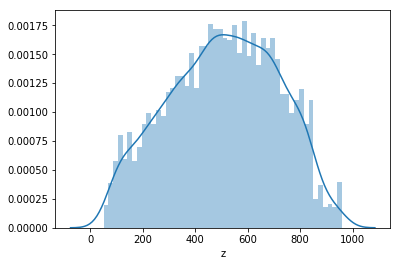

In [16]:
sns.distplot(train.z,bins=50,kde=True)

Text(0.5, 0.98, 'Salt Coverage')

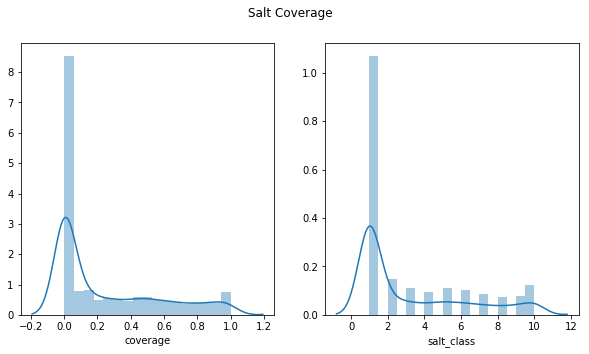

In [17]:
fig,axis = plt.subplots(1,2,figsize=(10,5))
sns.distplot(train.coverage,ax=axis[0])
sns.distplot(train.salt_class,ax=axis[1])
plt.suptitle("Salt Coverage")

Text(0.5, 0.98, 'Blue : Salt coverage. Top Left : Salt coverage class')

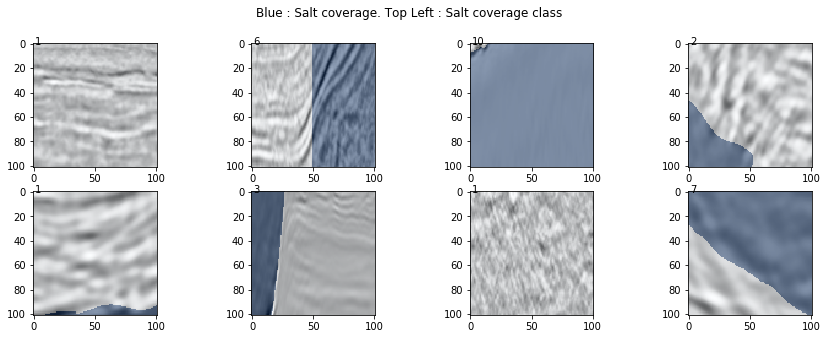

In [18]:
total_grid=8
grid_height=2
grid_width=int(total_grid/grid_height)

fig,axis = plt.subplots(grid_height,grid_width,figsize=(15,5))

for i,k in enumerate(train.index[:total_grid]):
    img = train.loc[k].images
    mask = train.loc[k].masks
    axs = axis[int(i/grid_width)][i%grid_width]
    axs.imshow(img,cmap="Greys")
    axs.imshow(mask,cmap="Blues",alpha=0.4)
    axs.text(1,1,train.loc[k].salt_class,color="black")
plt.suptitle("Blue : Salt coverage. Top Left : Salt coverage class")

### Upscale / Downscale image

In [19]:
from skimage.transform import resize

In [20]:
def upscale(img):
    return resize(img, (128,128))

def downscale(img):
    return resize(img, (101,101))

### Train Test split

In [22]:
from sklearn.model_selection import train_test_split

In [57]:
## For Testing purposes only fisrt 200 images & their masks have been taken. 

In [24]:
x_train,x_valid = train_test_split(np.array(train.images[:200].map(upscale).tolist()).reshape(-1,128,128,1) ,stratify=train.salt_class[:200],test_size=0.2,random_state=3)

y_train,y_valid = train_test_split(np.array(train.masks[:200].map(upscale).tolist()).reshape(-1,128,128,1) ,stratify=train.salt_class[:200],test_size=0.2,random_state=3)

In [39]:
ids_train, ids_valid = train_test_split(train.index.values[:200],test_size=0.2,random_state=3)

### Data Augmentation

In [25]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [41]:
preds_valid = model.predict(x_valid).reshape(-1, 128, 128)
preds_valid = np.array([downscale(x) for x in preds_valid])
y_valid_ori = np.array([train.loc[idx].masks for idx in ids_valid])

### Model Building Using Keras

The U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany.The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations<br>

The U-Net is a more elegant architecture, the so-called “fully convolutional network”<br>

The main idea is to supplement a usual contracting network by successive layers, where pooling operations are replaced by upsampling operators. Hence these layers increase the resolution of the output. What’s more, a successive convolutional layer can then learn to assemble a precise output based on this information<br>
<a href="https://en.wikipedia.org/wiki/U-Net"> More </a>

![alt text](https://www.depends-on-the-definition.com/wp-content/uploads/2018/07/unet-945x369.png)


Src : https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

### Simple CNN
![alt_text](https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-conv2d/keras_conv2d_padding.gif)

In [28]:
from keras import Model
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

In [29]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((128, 128, 1))
output_layer = build_model(input_layer, 16)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [30]:
model = Model(input_layer, output_layer)

In [31]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 10
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Instructions for updating:
Use tf.cast instead.
Train on 320 samples, validate on 40 samples
Epoch 1/10
320/320 [==============================] - ETA: 2:00 - loss: 0.6878 - acc: 0.710 - ETA: 1:23 - loss: 0.6866 - acc: 0.704 - ETA: 1:05 - loss: 0.6819 - acc: 0.747 - ETA: 51s - loss: 0.6792 - acc: 0.742 - ETA: 40s - loss: 0.6743 - acc: 0.74 - ETA: 31s - loss: 0.6691 - acc: 0.74 - ETA: 22s - loss: 0.6686 - acc: 0.73 - ETA: 14s - loss: 0.6490 - acc: 0.75 - ETA: 7s - loss: 0.6436 - acc: 0.7555 - 74s 231ms/step - loss: 0.6431 - acc: 0.7463 - val_loss: 0.5867 - val_acc: 0.7445

Epoch 00001: val_loss improved from inf to 0.58675, saving model to ./keras.model
Epoch 2/10
320/320 [==============================] - ETA: 55s - loss: 0.5108 - acc: 0.83 - ETA: 49s - loss: 0.5604 - acc: 0.77 - ETA: 42s - loss: 0.5566 - acc: 0.77 - ETA: 36s - loss: 0.5266 - acc: 0.79 - ETA: 30s - loss: 0.5727 - acc: 0.76 - ETA: 24s - loss: 0.5598 - acc: 0.77 - ETA: 18s - loss: 0.5611 - acc: 0.77 - ETA: 12s - loss: 0.

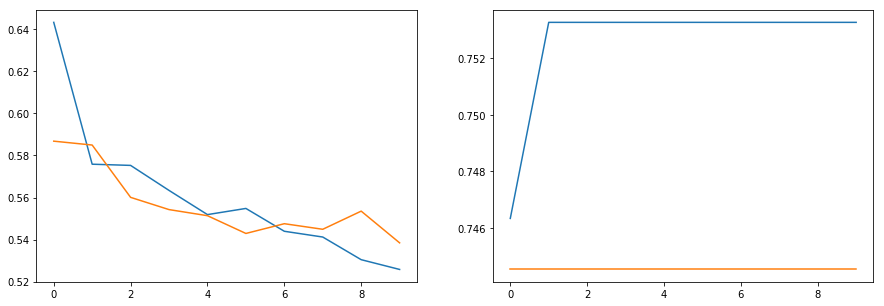

In [33]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

### Scoring

In [34]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [42]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [43]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

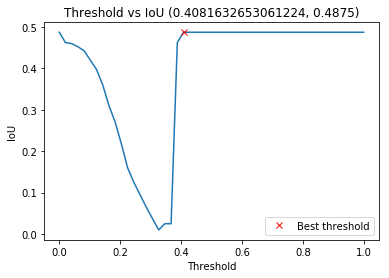

In [44]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

### Function to convert image into RL Encoding

In [45]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

### Load Test Images

In [46]:
## Get the file names of 'test' images and store them in 'test_df' after converting the list into DataFrame

import fnmatch
import os

test_df=pd.DataFrame({'id' :[f for f in os.listdir("./data/test/images") if fnmatch.fnmatch(f, '*.PNG')]})

In [47]:
# File name would also include file extension
# Replace file name containing '.png' to ''. 

test_df["id"] = test_df["id"].str.replace(".png","")

In [48]:
# Images column is not the index column of 'test_df'
# Make Images column as Index column 

test_df=test_df.head(len(test_df)).set_index('id')

In [ ]:
test_df['images']= [np.array(load_img("./data/test/images/{}.png".format(i),grayscale=True))/255 for i in tqdm_notebook(test_df.index)]

In [50]:
test_df.head()

,images
id,
010452a624,"[[0.29411764705882354, 0.3176470588235294, 0.3..."
02b224b871,"[[0.34509803921568627, 0.34509803921568627, 0...."
068f7a5267,"[[0.6313725490196078, 0.6549019607843137, 0.67..."
09eb37dca0,"[[0.4745098039215686, 0.4666666666666667, 0.45..."
0b45162089,"[[0.37254901960784315, 0.3764705882352941, 0.3..."


In [ ]:
x_test = np.array([upscale(np.array(load_img("./data/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, 128, 128, 1)

In [53]:
preds_test = model.predict(x_test)

In [55]:
pred_dict = {idx: RLenc(np.round(downscale(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [56]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')